# EDA for Used Car Data

<div class="alert alert-block alert-info">
    
### Source Dataset :  

9337 used car listings scraped from a car website and augmented with additional data.
Please refer to the file UsedCarDataPreparation for details on the data synthesis

### EDA Objectives: 

1. Describe basic statistical data of the dataset
2. Explore data quality - Variances, Outliers, Distributions, Skewness
3. Perform label encoding and explore relationships
4. Execute initial basic model and explore results.

</div>



In [1]:
# Libraries for data processing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_colwidth',0)
pd.set_option('display.float_format',lambda x: '%.2f' %x)
pd.set_option('display.max_rows',300)
pd.set_option('display.max_columns',0)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import missingno as msno
import itertools
import math
from datetime import datetime


In [2]:
# Libraries for modeling and encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from xgboost import XGBRegressor,plot_importance
from sklearn.metrics import mean_absolute_error,roc_curve, auc,mean_squared_error,make_scorer,classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import uniform, truncnorm, randint
from mlxtend.regressor import StackingCVRegressor

In [3]:
# Plot functions

def boxplots(df,columns):
    
    df1 = df[columns].copy()

    for col in df1.select_dtypes(exclude=['float64','int64']):
        df1[col] = df1[col].astype('category')
        df1[col] = df1[col].cat.codes        
    
    N = len(columns)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.3,hspace=0.9)
    fig = plt.figure(figsize=(22, 10))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        sns.boxplot( y=df1[columns[n]],palette="Set3",orient = 'h',ax = ax )
        ax.grid(True)
        ax.set_title('Distribution of '+ columns[n], fontsize=15) 


def scatterplots(df,x_cols,y_col):

    N = len(x_cols)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.2,hspace=0.8)
    fig = plt.figure(figsize=(21, 6))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        sns.scatterplot(x = x_cols[n], y = y_col, data=df, ax = ax)
        ax.set_title(x_cols[n] + ' vs ' + y_col, fontsize=15) 


def histograms(df, columns,xlen):        
    N = len(columns)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.3,hspace=1.0)
    fig = plt.figure(figsize=(xlen, 6))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        df[columns[n]].value_counts().plot(kind = 'bar',ax = ax)
        ax.set_title(columns[n], fontsize=15)      

def getmissing(df):
    s = df.isnull().sum() 
    s = s[s>0]
    if len(s) == 0:
        print("There are no columns with nulls")
        return
    print("Columns with missing data: \n")
    print(s)
    s.plot(kind = 'barh')
    
def info(df):  
    print(str(len(df.columns)) + ' columns') 
    df1 = pd.concat([df.nunique(),df.isnull().sum(),df.dtypes], axis = 1)
    df1.columns = ['unique values','nullvalues','data type']
    print(df1['data type'].value_counts())
    return df1

def sample(df):
    return df.sample(5, random_state = 10)


In [4]:
# boxplots(df = df, columns = ['year','AvgMPG','accidenthist','owner'])
# scatterplots(df = df, x_cols = ['PercentSales', 'AvgDaysToTurn','ReviewScore', 'AvgMPG'], y_col = 'price', make = 'HONDA')
# histograms(df = df , columns = ['year','pricecategory', 'accidenthist', 'owner','make','usage'])

# <span style="color:Blue"> Step 1: Read dataset, describe basic statistical data of the dataset, missing values </span>

In [5]:
# read the cars data from csv
df = pd.read_csv('cardata_final.csv',encoding = "ISO-8859-1",index_col=False)

In [6]:
# Shuffle the dataset with df.sample(frac=1)
# Split the data set into a train+test set (80%) and a holdout set (20%)
# holdout set will be used for final model testing
df, df_hold = np.split(df.sample(frac=1), [int(.8*len(df))])

In [7]:
len(df)

7469

In [8]:
len(df_hold)

1868

In [9]:
sample(df)

,vin,year,make,model,trim,pricecategory,price,mileage,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid
844,5NPD84LF9KH441262,2019,HYUNDAI,ELANTRA,SEL 2.0L AUTOMATIC,EXCELLENT PRICE,13599,34988,CENTENNIAL,CO,BLACK,BLACK,0,1,FLEET,Y,SEDAN,13.00,33,4.16,79.08,8.10,31.00,N
847,3N1AB7AP7HY309004,2017,NISSAN,SENTRA,SV CVT,EXCELLENT PRICE,9500,63462,WINCHESTER,VA,GRAY,BLACK,0,2,PERSONAL,Y,SEDAN,16.00,31,6.29,76.23,7.20,33.00,N
9218,4JGDF6EE6FA499392,2015,MERCEDES-BENZ,GL,GL 450 4MATIC,EXCELLENT PRICE,23000,74555,ORLAND PARK,IL,GRAY,BLACK,0,1,PERSONAL,Y,SUV,22.00,9,2.21,57.92,8.40,19.00,Y
3480,KNMAT2MT7KP512330,2019,NISSAN,ROGUE,SV FWD,GREAT PRICE,16990,23419,BRADDOCK HEIGHTS,MD,WHITE,BLACK,0,1,PERSONAL,Y,SUV,16.00,45,6.29,76.23,7.40,29.50,N
8553,4T1BF1FKXHU644224,2017,TOYOTA,CAMRY,XLE I4 AUTOMATIC,EXCELLENT PRICE,16993,24392,GREENFIELD,WI,GRAY,BEIGE,0,2,PERSONAL,Y,SEDAN,5.00,24,12.19,43.23,8.70,35.00,N


In [10]:
info(df)

24 columns
object     13
int64      6 
float64    5 
Name: data type, dtype: int64


,unique values,nullvalues,data type
vin,7469,0,object
year,24,0,int64
make,45,0,object
model,374,0,object
trim,1219,0,object
pricecategory,4,0,object
price,3654,0,int64
mileage,7121,0,int64
city,1330,0,object
state,50,0,object


In [11]:
df.describe()

,year,price,mileage,accidenthist,owner,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG
count,7469.00,7469.00,7469.00,7469.00,7469.00,7406.00,7469.00,7410.00,7398.00,6921.00,6915.00
mean,2016.37,16765.89,54106.31,0.19,1.43,14.47,25.96,6.78,70.73,7.86,28.04
std,3.97,9048.53,45937.60,0.48,0.90,6.82,14.40,4.36,15.77,0.58,6.71
min,1997.00,1500.00,6.00,0.00,0.00,2.00,1.00,0.00,23.23,5.30,15.00
25%,2015.00,10775.00,25839.00,0.00,1.00,9.00,14.00,2.22,57.92,7.40,23.50
50%,2018.00,15780.00,35937.00,0.00,1.00,14.00,27.00,6.29,74.23,7.90,28.50
75%,2019.00,19998.00,72600.00,0.00,2.00,18.00,38.00,11.69,78.23,8.30,32.00
max,2020.00,74227.00,395720.00,5.00,10.00,32.00,52.00,13.83,123.69,9.30,131.00


<div class="alert alert-block alert-success">
    
### Results and Observations for Step 1 - Basic Stats on data :

1. 24 columns are present in the data set consisting of 11 numerical and 13 non-numerical variables
    
2. As this data set is generated as part of data acquisition phase of this project , _most of the data is already standardized during the data synthesis process_.   
    
3. Nulls observed in a group of fields which are related to market reviews and sales. This is due to unavailability of data for those makes - most of them are European makes or super luxury brands.
    
4. Proposed target variables - "price" and "pricecategory" are all non-null. 
    
5. Most of the cars listed are either 1 or 3 years old. 25% to 75% of the cars are within 2015 to 2019.
    
6. 75% of the listings have prices within 20k. Most of the cars are in range 10-20k. Typical of used car values for cars older than 2 years.
    
7. Nissan, Ford, Toyota, Hyndai, Chevrolet and Honda are the most frequently occuring Makes in the listing.
    
  
</div>


## <span style="color:Blue"> Step 2: Explore data quality - Variances, Missing Values, Outliers, Distributions, Skewness </span>

### Missing data analysis


Columns with missing data: 

ReliabilityRank         63 
PercentSales            59 
AvgDaysToTurn           71 
ReviewScore             548
AvgMPG                  554
LuxurySportsOrHybrid    548
dtype: int64


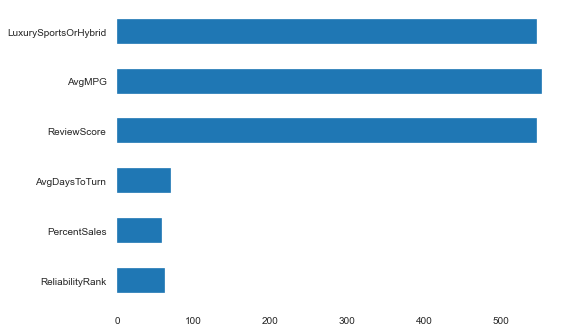

In [12]:
getmissing(df)

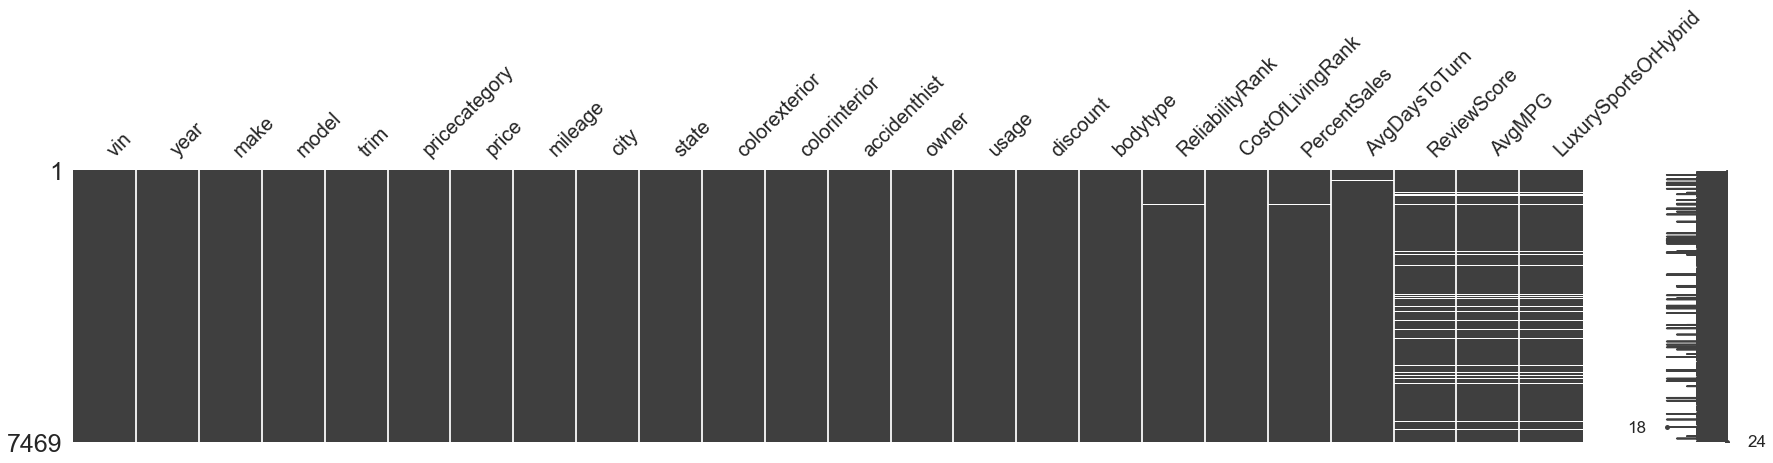

In [13]:
msno.matrix(df,figsize=(30,5), fontsize=20)

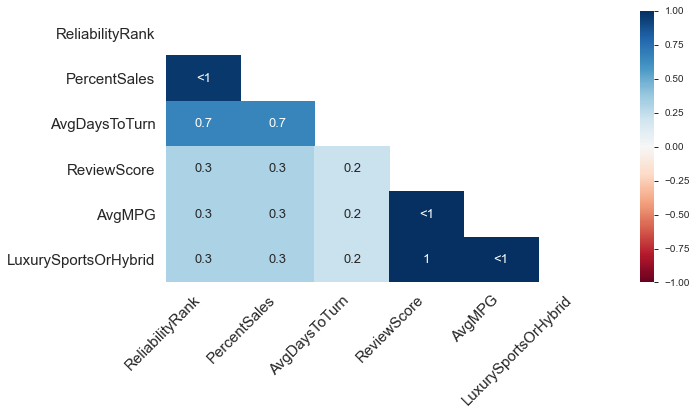

In [14]:
msno.heatmap(df,figsize=(10,5), fontsize=15)

<div class="alert alert-block alert-danger">
    
<br>   
   
#### **OBSERVATION : Missing Values**

    
- The NULL vlues in the columns are not clustered around any specific point, it is evenly distributed.
    
- Columns with Null value show correlations - this is because they are extracted from same or similar datasets from same population sample (reviews for a particular year range or specific makes)
   
<br>    
- (ReliabilityRank,PercentSales,AvgDaysToTurn)  are highly correlated for NULL values as they come from similar data set
<br>
- (ReviewScore, AvgMPG,LuxurySportsOrHybrid)  are perfectly correlated for NULL values as they come from same data set.

<br>
    
_The samples with null values are either from Super Luxury brands or from models older than 2012 which were beyond the scope of the data capture process._
 
#### **ACTION : Imputation of missing values  


| Columns with Missing Values |  Impute Strategy 
| --- |  --- 
| AvgMPG,ReliabilityRank,PercentSales,AvgDaysToTurn,ReviewScore | -1
| LuxurySportsOrHybrid  |  'U'

    
- Add a new columns to indicate absence of data for the above fields as described below:

    
| New Indicator Column | Value determination
| --- |  --- 
| ReviewDataAvailable | 'N' if **any one** of the following columns is NULL, else 'Y'
    
    

   
</div>

### Skew and Outlier analysis


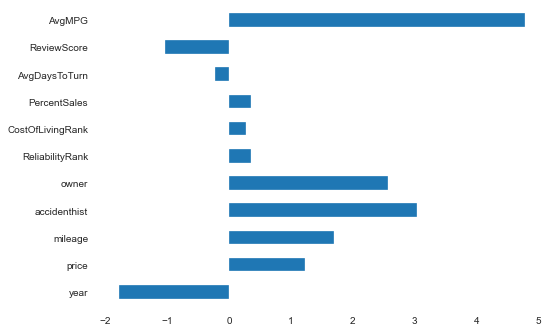

In [15]:
# check Skewness of columns
df.skew().plot(kind = 'barh')

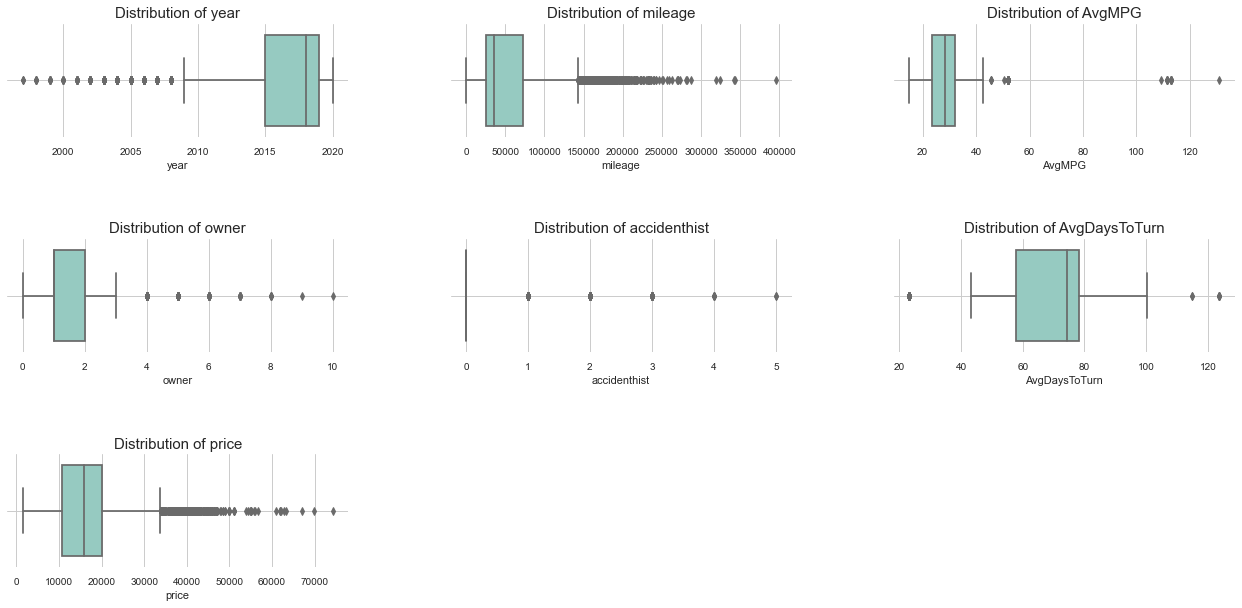

In [16]:
boxplots(df = df, columns = ['year','mileage','AvgMPG','owner','accidenthist','AvgDaysToTurn','price'])

<div class="alert alert-block alert-danger">

#### **OBSERVATION : Skewness**

- Most of the columns have the common/usual values seen in used car data. So these do not really have outliers. 
    
    accidenthist,owner show skewness in the typical values of used cars  <br>
    year shows skewness for 2015 - 2019 which is typical age of listed used cars <br>
    reviewscore has lot of values 6.5 to 8 <br>
    

#### **OBSERVATION : Outliers**

- **Outliers seen for year < 2008** : It is common for used cars listings to have cars older than 10-15 years. 
    
- **Outliers seen for mileage > 150000** : It is common for used cars to have mileage > 150000, but here mileage values > 250000 are observed

- **Outliers seen for AvgMPG > 45** :  Electric/Hybrid/small may have AvgMPG > 45
    
- **Outliers seen for owner > 4** :  It is common for used cars listings to have more than 1 owners
    
- **Outliers seen for accidenthist > 0** :  It is uncommon for used car listings to have more than 2 accidents, No accident is most common

- **Outliers seen for price > 35000** :  Prices beyond 50k is very rare unless for used cars
    
    
#### **ACTION : Creation of Dervied features**
    
Deriving new categorical features will help in reducing the effect of outliers
    
    
</div>

### Missing data handling - imputations, creation of additional attributes 

In [17]:
# Function to clip outliers outside mean +- 2SD
def clipoutliers_2SD(df,columns):
    df2 = df.copy()    
    for col in columns:          
        ulim = df2[col].mean() + 2*df2[col].std()
        llim = df2[col].mean() - 2*df2[col].std()
        df2[col] = df2[col].clip(llim,ulim)
    return df2

In [18]:
# Reduce the number of possible values of a feature
# Either by creating new features or converting them into categorical


#Add the new column to indicate availability of reviews/ratings data, if there is a null in any column, fill as N
df.loc[df.isnull().any(axis=1),'ReviewDataAvailable'] = 'N'
#for all other columns where all data is available, fill Y
df['ReviewDataAvailable'].fillna('Y',inplace = True)

# Imputation for columns: 'AvgMPG','ReliabilityRank','PercentSales','AvgDaysToTurn','ReviewScore' set to column median
for col in ['AvgMPG','ReliabilityRank','PercentSales','AvgDaysToTurn','ReviewScore']:
    df[col] = df[col].fillna(df[col].median()) 


# Imputation for 'LuxurySportsOrHybrid', set as 'U' - unknown
df['LuxurySportsOrHybrid'].fillna('U',inplace = True)

   
# extract drivetrain from the trim
# missing data is assigned FWD. 
# FWD and 2WD is mapped to FWD
# AWD, RWD, 4WD are mapped to 4WD
df['drivetrain'] = df['trim'].apply(lambda x:[d for d in ['AWD','RWD','FWD','4WD','2WD'] if d in x])
df['drivetrain'] = df['drivetrain'].apply(lambda x:x[0] if len(x) > 0 else 'FWD')
df['drivetrain'] = df['drivetrain'].apply(lambda x:'FWD' if x in ['FWD','2WD'] else 'AWD')    
    
# convert year to age
df['age'] = 2020 - df['year'] 

# convert mileage value to thousands and rename to odo
df['odo'] = df['mileage']/1000 

# Convert to categorical 
# convert owners and accidenthist to 3 groups
df['owner'] = pd.cut(x=df['owner'], bins=[-1,0,1,20], labels=[0,1,2])
df['accidenthist'] = pd.cut(x=df['accidenthist'], bins=[-20,0,20], labels=['N', 'Y'])


# clip outliers to mean +/- 2 SD
df = clipoutliers_2SD(df = df,columns = ['age','odo','AvgMPG','AvgDaysToTurn','price'])

# drop the root columns that were used to derive the categorical columns
df = df.drop(columns = ['year','trim','mileage']) 


In [19]:
sample(df)

,vin,make,model,pricecategory,price,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid,ReviewDataAvailable,drivetrain,age,odo
844,5NPD84LF9KH441262,HYUNDAI,ELANTRA,EXCELLENT PRICE,13599.00,CENTENNIAL,CO,BLACK,BLACK,N,1,FLEET,Y,SEDAN,13.00,33,4.16,79.08,8.10,31.00,N,Y,FWD,1.00,34.99
847,3N1AB7AP7HY309004,NISSAN,SENTRA,EXCELLENT PRICE,9500.00,WINCHESTER,VA,GRAY,BLACK,N,2,PERSONAL,Y,SEDAN,16.00,31,6.29,76.23,7.20,33.00,N,Y,FWD,3.00,63.46
9218,4JGDF6EE6FA499392,MERCEDES-BENZ,GL,EXCELLENT PRICE,23000.00,ORLAND PARK,IL,GRAY,BLACK,N,1,PERSONAL,Y,SUV,22.00,9,2.21,57.92,8.40,19.00,Y,Y,FWD,5.00,74.56
3480,KNMAT2MT7KP512330,NISSAN,ROGUE,GREAT PRICE,16990.00,BRADDOCK HEIGHTS,MD,WHITE,BLACK,N,1,PERSONAL,Y,SUV,16.00,45,6.29,76.23,7.40,29.50,N,Y,FWD,1.00,23.42
8553,4T1BF1FKXHU644224,TOYOTA,CAMRY,EXCELLENT PRICE,16993.00,GREENFIELD,WI,GRAY,BEIGE,N,2,PERSONAL,Y,SEDAN,5.00,24,12.19,43.23,8.70,35.00,N,Y,FWD,3.00,24.39


#### POST-IMPUTE AND STANDARDIZATION CHECKS

In [20]:
# Check null value distribution after impute
getmissing(df)

There are no columns with nulls


In [21]:
info(df)

25 columns
object      14
float64     8 
category    1 
category    1 
int64       1 
Name: data type, dtype: int64


,unique values,nullvalues,data type
vin,7469,0,object
make,45,0,object
model,374,0,object
pricecategory,4,0,object
price,3347,0,float64
city,1330,0,object
state,50,0,object
colorexterior,17,0,object
colorinterior,9,0,object
accidenthist,2,0,category


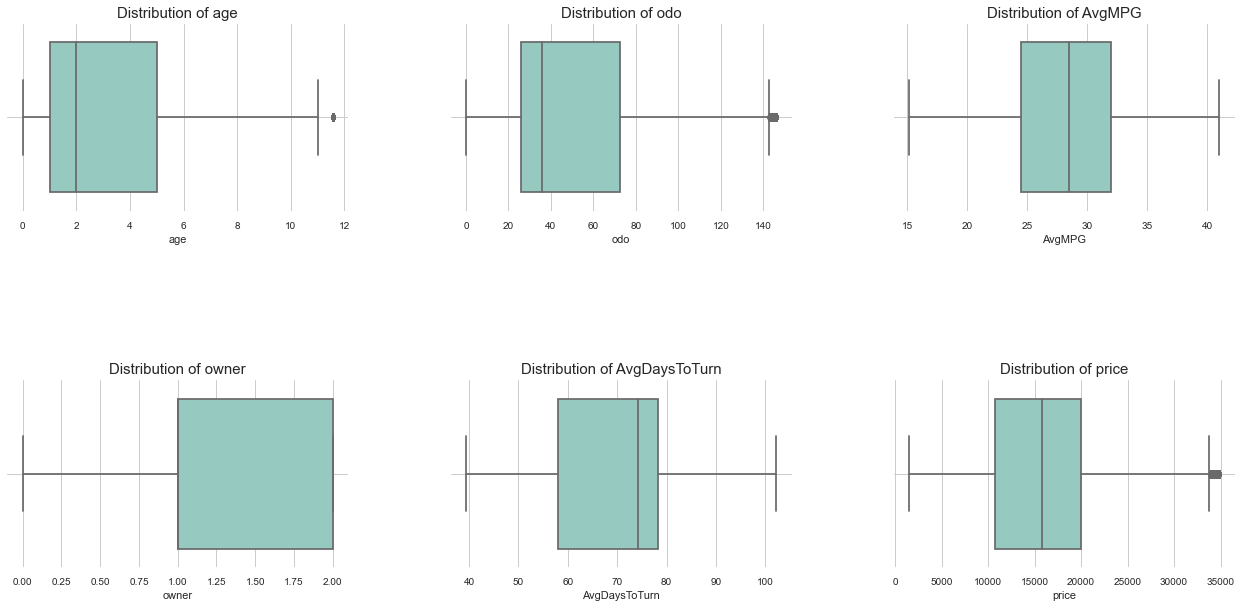

In [22]:
boxplots(df = df, columns = ['age','odo','AvgMPG','owner','AvgDaysToTurn','price'])

<div class="alert alert-block alert-success">
    
### Results and Observations for Step 2 - Handling missing data and outliers:

1. All missing data were imputed based on the logic described above.
    
2. Outliers have been detected and removed to mean +/- 2SD. 
    
3. Derived columns have been created from  the columns having outliers and original columns have been removed.
    
</div>


## <span style="color:Blue"> Step 3: Explore relationships </span>

#### Get a subset of the most listed make models

In [23]:
df1 = df.copy()
df1['makemodel'] = df1['make'].astype(str) + ' ' +  df1['model'].astype(str)
df1 = df1[['makemodel','pricecategory', 'price','state','CostOfLivingRank','colorexterior', 'colorinterior', 'accidenthist', 'owner', 'usage','discount','age','odo']]
df1.loc[:,'odo'] = df1.loc[:,'odo'].apply(lambda x:round(x,0))
df1.loc[:,'price'] = df1.loc[:,'price'].apply(lambda x:round(x/100,2))
df1.groupby(['makemodel']).size().reset_index(name='count').sort_values(['count'], ascending = False).head(10)

,makemodel,count
161,HYUNDAI ELANTRA,418
294,NISSAN ROGUE,381
297,NISSAN SENTRA,352
105,DODGE GRAND CARAVAN,345
131,FORD FUSION,319
338,TOYOTA CAMRY,256
282,NISSAN ALTIMA,238
340,TOYOTA COROLLA,237
150,HONDA CIVIC,217
149,HONDA ACCORD,204


#### Filter data for the three most common make model

In [24]:
df1 = df1[(df1['makemodel'].isin(['HYUNDAI ELANTRA','NISSAN ROGUE','NISSAN SENTRA']))]

#### Plot Odometer vs Price : age/owner/accidenthist constant
_Negative correlation observed between odometer and price_

_price cateogories dont show any specific relationships_

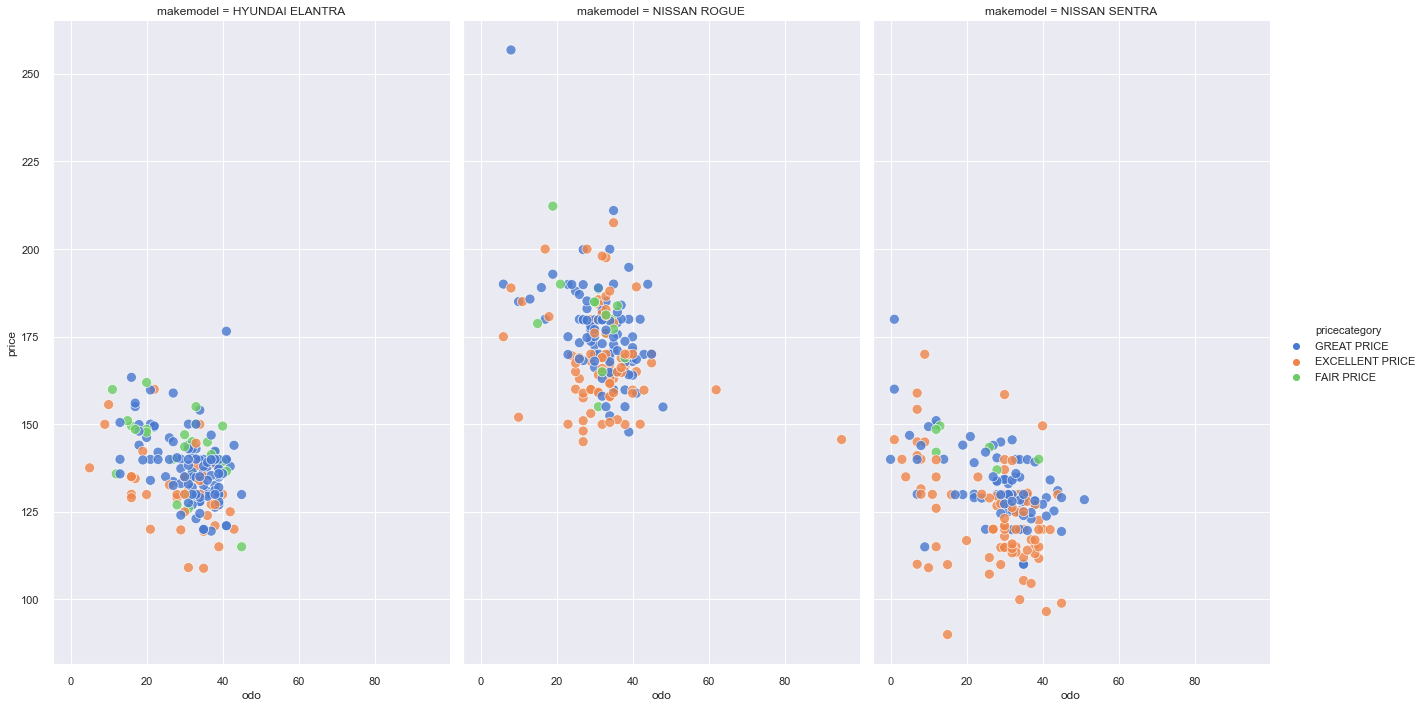

In [26]:
sns.set(style="darkgrid")
sns.relplot(x = 'odo', y = 'price', 
                hue='pricecategory', 
                alpha=.8, 
                palette="muted", 
                height=10,
                aspect=0.6,
                col = 'makemodel',
                s=100,
                data=df1[(df1['owner'] == 1) & (df1['age'] == 1) & (df1['accidenthist'] == 'N')]) 


#### Plot CostOfLivingRank  vs Price : odometer/owner/age constant
_No correlation observed between CostOfLivingRank and price_

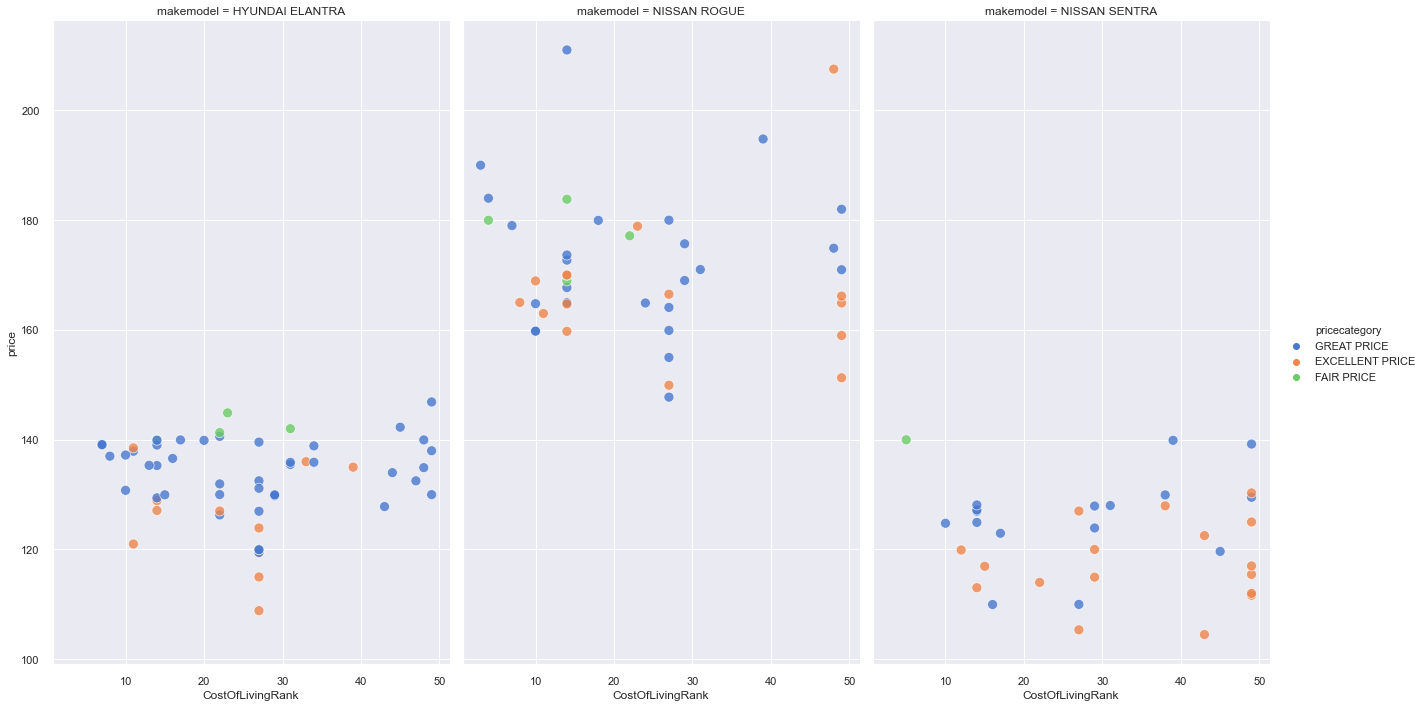

In [27]:
sns.set(style="darkgrid")
sns.relplot(x = 'CostOfLivingRank', y = 'price', 
                hue='pricecategory', 
                alpha=.8, 
                palette="muted", 
                height=10,
                aspect=0.6,
                col = 'makemodel',
                s=100,
                data=df1[(df1['odo'].between(35,39)) & (df1['owner'] == 1) & (df1['age'] == 1) & (df1['accidenthist'] == 'N')]) 


#### Plot Age  vs Price : odometer/owner constant
_Negative correlation observed between age and price_

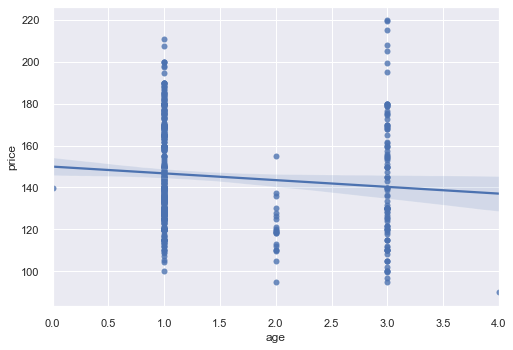

In [28]:
sns.set(style="darkgrid")
sns.regplot(x = 'age', y = 'price', 
               
                data=df1[(df1['odo'].between(20,39)) & (df1['owner'] == 1) & (df1['accidenthist'] == 'N')]) 


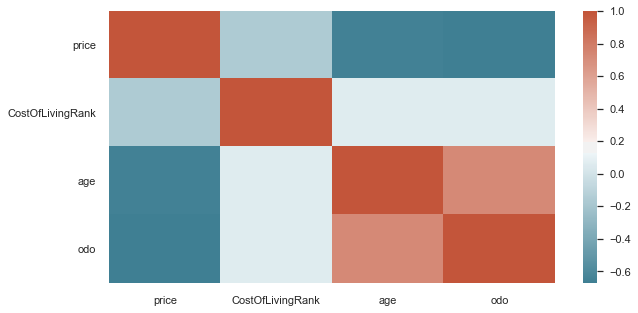

In [29]:
# plot the correlation heatmap for all columns
corr = df1.corr()
plt.figure(figsize = (10,5))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, cmap=sns.diverging_palette(220, 20, as_cmap=True))

## <span style="color:Blue"> Step 4: Encode Data </span>

In [30]:
# drop unwanted columns 
df2 = df.copy()
df2 = df2.drop(columns = ['vin', 'city', 'state','make','model'])
# create onehot for the columns with low cardinality
dum_cols = ['owner', 'usage', 'discount','LuxurySportsOrHybrid','drivetrain','accidenthist']
df2 = pd.get_dummies(df2, columns = dum_cols)

In [31]:
info(df2)

28 columns
uint8      14
float64    8 
object     5 
int64      1 
Name: data type, dtype: int64


,unique values,nullvalues,data type
pricecategory,4,0,object
price,3347,0,float64
colorexterior,17,0,object
colorinterior,9,0,object
bodytype,10,0,object
ReliabilityRank,31,0,float64
CostOfLivingRank,50,0,int64
PercentSales,33,0,float64
AvgDaysToTurn,29,0,float64
ReviewScore,32,0,float64


In [32]:
# create a custom Encoder class to handle new unseen values as UNKNOWN 
# this is an extension of the sklearn Label Encoder class
class MyLabelEncoder():
    
    # initialize encoder with base constructor of LabelEncoder
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, values):
        # add a category "UNKNOWN"
        # this will be used as the category when an "unseen" value shows up in the data set
        self.encoder = self.encoder.fit(list(values) + ['UNKNOWN'])
        self.classes_ = self.encoder.classes_

    def transform(self,values):

        values = list(values)
        # for each item in new values
        for item in np.unique(values):
            # if the item is not in the encoder classes (new unseen value   ) mark it as 'UNKNOWN'
            if item not in self.classes_:
                values = ['UNKNOWN' if x == item else x for x in values]

        return self.encoder.transform(values)

# Function to build encoder list for columns which are non-numeric
# Generate a dictionary of encoders to be used for test set
def generate_label_encoders(df):

    encdict = {}

    for col in df.select_dtypes(include = ['object']).columns:
        enc = MyLabelEncoder()
        enc.fit(df[col])
        encdict.update({col : enc})

    return encdict 


# Encode the data using the passed in encoders

def encode_data(df,encoders):

    df1 = df.copy()

    for col in df1.select_dtypes(include = ['object']).columns:
        df1[col]  = encoders[col].transform(df1[col])

    return df1

In [33]:
encoders = generate_label_encoders(df2)

In [34]:
df2 = encode_data(df2,encoders)

In [35]:
sample(df2)

,pricecategory,price,colorexterior,colorinterior,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,ReviewDataAvailable,age,odo,owner_0,owner_1,owner_2,usage_FLEET,usage_PERSONAL,discount_N,discount_Y,LuxurySportsOrHybrid_N,LuxurySportsOrHybrid_U,LuxurySportsOrHybrid_Y,drivetrain_AWD,drivetrain_FWD,accidenthist_N,accidenthist_Y
844,0,13599.00,1,1,4,13.00,33,4.16,79.08,8.10,31.00,2,1.00,34.99,0,1,0,1,0,0,1,1,0,0,0,1,1,0
847,0,9500.00,5,1,4,16.00,31,6.29,76.23,7.20,33.00,2,3.00,63.46,0,0,1,0,1,0,1,1,0,0,0,1,1,0
9218,0,23000.00,5,1,6,22.00,9,2.21,57.92,8.40,19.00,2,5.00,74.56,0,1,0,0,1,0,1,0,0,1,0,1,1,0
3480,2,16990.00,15,1,6,16.00,45,6.29,76.23,7.40,29.50,2,1.00,23.42,0,1,0,0,1,0,1,1,0,0,0,1,1,0
8553,0,16993.00,5,0,4,5.00,24,12.19,43.23,8.70,35.00,2,3.00,24.39,0,0,1,0,1,0,1,1,0,0,0,1,1,0


In [36]:
info(df2)

28 columns
uint8      14
float64    8 
int64      6 
Name: data type, dtype: int64


,unique values,nullvalues,data type
pricecategory,4,0,int64
price,3347,0,float64
colorexterior,17,0,int64
colorinterior,9,0,int64
bodytype,10,0,int64
ReliabilityRank,31,0,float64
CostOfLivingRank,50,0,int64
PercentSales,33,0,float64
AvgDaysToTurn,29,0,float64
ReviewScore,32,0,float64


In [37]:
# Ensure No Nulls
assert df2.isnull().sum().sum() == 0

In [38]:
# Ensure No Non-Numeric
assert len(df2.select_dtypes(exclude = ['int64','float64','uint8']).columns) == 0 

<div class="alert alert-block alert-success">

### RESULT:  Data Encoding -  ALL NUMERIC , NO NULLS
    
- all categorical columns have been label encoded to numeric
- no non-numeric columns are present in the data set
- no null values are present in the data set
    
</div>

## <span style="color:Blue"> Step 5: Prepare feature vectors and execute Train-Test Split in 80/20 ratio </span>

In [39]:
# Get dependent and independent variables in arrays

# X is all columns except price
X = df2.loc[:,~df2.columns.isin(['price','pricecategory']) ]
X_labels = df2.columns[~df2.columns.isin(['price','pricecategory'])]
y = df2['price']

# Train and Test for target variable "price"
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)


## <span style="color:Blue"> Step 5: Explore multiple models </span>

The following models are explored. _2 ensemble tree based models and 2 linear models are selected for analysis_

- Random Forest Regressor
- XG Boost Regressor
- Linear Regressor
- SVM Regressor with RBF kernel

### <span style="color:Blue"> Explore invididual models </span>


#### <span style="color:Red"> Class - Ensemble Tree based </span>
#### <span style="color:Red"> Type -  Random forest regressor </span>

In [ ]:
# Get random forest regressor

def featureimportance(model,index):
    
    feat_price = pd.DataFrame(model.feature_importances_,
                              index = index,
                              columns = ['ImportanceScore']
                              )
    feat_price.sort_values('ImportanceScore', ascending = True).plot(kind = 'barh')
    
    
    
# Create a Random Forest Regressor with default parameters
rf_price = RandomForestRegressor(random_state=1, 
                                 n_estimators = 1000, 
                                 max_depth = 20,
                                 max_features = 'auto',
                                 min_samples_leaf = 4,
                                 min_samples_split = 5)

rf_price.fit(X_train, y_train)

pred_price = rf_price.predict(X_test)

print("\nMean Absolute Error (Random Forest): {}".format(round(mean_absolute_error(y_test, pred_price))))
print("\nModel Score (Random Forest): {}".format(rf_price.score(X_test,y_test)))
#print("\nModel Params (Random Forest): {}".format(rf_price.get_params()))

featureimportance(rf_price,X_labels)

### <span style="color:Red"> Model 2 -  XG Boost (XGBRegressor) </span>

In [ ]:
# Create an XGB Regressor

xg_price = XGBRegressor(objective ='reg:squarederror', 
                        colsample_bytree = 0.3, 
                        learning_rate = 0.1,
                        max_depth = 5, 
                        alpha = 10, 
                        n_estimators = 1000)

xg_price.fit(X_train, y_train)

xg_pred_price = xg_price.predict(X_test)

print("\nMean Absolute Error (XGBoost): {}".format(round(mean_absolute_error(y_test, xg_pred_price))))
print("\nModel Score (XGBoost): {}".format(xg_price.score(X_test,y_test)))
#print("\nModel Params (XGBoost): {}".format(xg_price.get_params()))

plot_importance(xg_price)

### <span style="color:Red"> Model 3 - SVM with RBF Kernel </span>

In [ ]:
# Create an XGB Regressor

svr_price = SVR(kernel='rbf')

svr_price.fit(X_train, y_train)

svr_pred_price = svr_price.predict(X_test)

print("\nMean Absolute Error: {}".format(round(mean_absolute_error(y_test, svr_pred_price))))
print("\nModel Score: {}".format(svr_price.score(X_test,y_test)))


<div class="alert alert-block alert-success">
    
## Results and Observations for Step 4 - Execute initial model 


### RandomForest Regressor  (1000 estimators)
    
Mean Absolute Error (Random Forest): 1439.0
Model Score (Random Forest): 0.9199413102727366 
Top features:
    
    odo
    AvgMPG
    age
    LuxurySportsOrHybrid
    ReviewScore
    PercentSales
    AvgDaysToTurn
    bodytype
    drivetrain
    ReliabilityRank
    CostOfLivingRank
    
### XGBRegressor Regressor (1000 estimators)
    
Mean Absolute Error (XGBoost): 1333.0
Model Score (XGBoost): 0.9320679624344501 
Top features:
    
    odo
    CostOfLivingRank
    ReviewScore
    AvgMPG
    ReliabilityRank
    AvgDaysToTurn
    PercentSales
    colorexterior
    age
    colorinterior
    bodytype

    
    
    
    
### SVM Regressor (kernel='rbf')    
    
Performs poorly
</div>


## Hyperparameter tuning 

#### Hyperparameters :  RandomForest 

1. n_estimators : number of decision trees in the forest   
2. max_features:  number of features to select (auto/sqrt/log)  
3. max_depth : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples 
4. min_samples_split : The minimum number of samples required to split an internal node
5. min_samples_leaf : The minimum number of samples required to be at a leaf node
6. max_samples : If bootstrap is True, the number of samples to draw from X to train each base estimator.


#### Hyperparameters :  XGBoost 

1. n_estimators : number of decision trees in the forest   
2. min_child_weight:  Minimum sum of instance weight(hessian) needed in a child
3. gamma :  Minimum loss reduction required to make a further partition on a leaf node of the tree
4. colsample_bytree :  Subsample ratio of columns when constructing each tree
5. max_depth : The maximum depth of the tree.  

### Tuning Random Forest Regressor : GridSearchCV

In [ ]:
# Create random search cross validation 
# Get the parameter value lists

# Create the random grid
param_grid = {  'max_depth': [50,70, 90, 110],
                'max_features': ['auto','sqrt','log2'],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10, 12],
                'n_estimators': [500, 1500, 3000]
            }


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Grid search of parameters, using 3 fold cross validation, 
gs = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search search model
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

### Tuning XGBoost Regressor : GridSearchCV

In [ ]:
print(f'start grid search with XGB at {datetime.now()}')
# Create random search cross validation 
# Get the parameter value lists
# Create the parameter
param_grid = {  
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5],
            'n_estimators' : [500,1000,1500]
            }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xg = XGBRegressor()
# Grid search of parameters, using 3 fold cross validation, 
gs = GridSearchCV(estimator = xg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search search model
gs.fit(X_train, y_train)

print(f'end grid search with XGB at {datetime.now()}')

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

### Tuning XGBoost : Hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
def model_cost(space):
    xg = XGBRegressor(n_estimators =space['n_estimators'], 
                       max_depth = int(space['max_depth']), 
                       gamma = space['gamma'],
                       reg_lambda = space['reg_lambda'],
                       min_child_weight=space['min_child_weight'],
                       colsample_bytree=space['colsample_bytree']
                       )

    xg.fit(X_train, y_train)
    pred = xg.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    return {'loss':mse, 'status': STATUS_OK, 'model': xg}

    
    
    
space= {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,3),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': 1000
        }


print(f'START Hyperopt with XGB at {datetime.now()}')
trials = Trials()
best = fmin(fn=model_cost,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)
print(f'END Hyperopt with XGB at {datetime.now()}')


In [ ]:
best

In [ ]:
xg_price = XGBRegressor(objective ='reg:squarederror', 
                         colsample_bytree = 0.51,
                         gamma = 2.43,
                         max_depth = 3,
                         min_child_weight = 7.0,
                         reg_lambda = 0.95,
                         n_estimators = 1000)

xg_price.fit(X_train, y_train)

xg_pred_price = xg_price.predict(X_test)
print("\nMean Absolute Error (XGBoost): {}".format(round(mean_absolute_error(y_test, svr_pred_price))))
print("\nModel Score (XGBoost): {}".format(svr_price.score(X_test,y_test)))

<div class="alert alert-block alert-success">
    
### Results and Observations for Hyperparameter tuning
    
#### GridSearchCV - RamdomForest
    
  {'max_depth': 90, <br/>
 'max_features': 'auto',<br/>
 'min_samples_leaf': 3,<br/>
 'min_samples_split': 8,<br/>
 'n_estimators': 3000}
    
  Best Score = 0.9137634998897927
    
#### GridSearchCV - XGBoost
    
{'colsample_bytree': 0.6,<br/>
 'gamma': 0.5,<br/>
 'max_depth': 3,<br/>
 'min_child_weight': 10,<br/>
 'n_estimators': 500}
    
#### Hyperopt - XGBoost
    
{'colsample_bytree': 0.5096056020274609,
 'gamma': 2.4253880796092018,
 'max_depth': 3.0,
 'min_child_weight': 7.0,
 'reg_lambda': 0.9540302602503645}
        
  Best Score =  0.9232975820614419

## Using a Stacking Regressor with Random Forest, XGBoost and SVR
### Refering to the optimal parameters obtained by individual model fitting

In [ ]:
from mlxtend.regressor import StackingCVRegressor

#Initializing Level One 
xgbr = XGBRegressor(n_estimators = 1000)
rf = RandomForestRegressor(n_estimators=1000, random_state=1)
lr = LinearRegression()
 
#Stacking the various regressors initialized before
stack = StackingCVRegressor(regressors=(xgbr ,rf, lr),meta_regressor= xgbr, use_features_in_secondary=True)

#Fitting the data
stack.fit(X_train,y_train)

#Predicting the Test set results
y_pred_stack = stack.predict(X_test)

#Evaluating
print("\n\nStackingCVRegressor SCORE : ", score(y_pred_stack, y_test))